## Analysing transportation data

In [1]:
import sys
!{sys.executable} -m pip install folium

In [2]:
import folium

m = folium.Map(
    location=[55.924550, -3.176920],
    zoom_start=15
)

In [3]:
m

I can mark the Murchison House on the map by a circle with `radius=50`

In [4]:
folium.CircleMarker(
    location=[55.924550, -3.176920],
    radius=50,
    color='blue',
    fill=True,
    fill_color='blue'
).add_to(m)

m

In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt

data_path = os.path.join(os.getcwd(), 'cyclingtrips_Sep2019.csv')
dataset = pd.read_csv(data_path, delimiter = ',', parse_dates=['started_at', 'ended_at'])

In [6]:
date_started = (dataset["started_at"])
dataset.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2019-09-01 00:02:24.545000+00:00,2019-09-01 00:18:32.932000+00:00,968,1039,Lothian Road,Outside the Usher Hall,55.947409,-3.205765,366,Dudley Gardens,Corner of Dudley Gardens on Newhaven Road,55.975921,-3.191346
1,2019-09-01 00:07:16.267000+00:00,2019-09-01 00:48:31.838000+00:00,2475,1028,The Tron,Next to Tron Kirk Royal Mile,55.950037,-3.187822,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622
2,2019-09-01 00:15:44.914000+00:00,2019-09-01 00:38:15.454000+00:00,1350,290,Bruntsfield links,Corner of Bruntsfield Terrace and Bruntsfield ...,55.937159,-3.206435,346,Morningside Road,Corner of Morningside Road & Morningside Park ...,55.927986,-3.209739
3,2019-09-01 00:27:39.308000+00:00,2019-09-01 00:43:45.157000+00:00,965,1028,The Tron,Next to Tron Kirk Royal Mile,55.950037,-3.187822,1025,Dundee Terrace,Corner of Dundee Street & Dundee Terrace,55.939710,-3.220589
4,2019-09-01 00:32:17.434000+00:00,2019-09-01 01:45:50.968000+00:00,4413,870,Hillside Crescent,East corner of Hillside Crescent & London Road,55.957793,-3.175799,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622


#### We will split the dataset in two new datasets according to the trips time started. We assume that the morning trips are between 00:00 and 11:59 and the afternoon trips are between 12:00 and 23:59.

In [7]:
#divide dataset in morning and afternoon
morning_indices = []
afternoon_indices = []

#save the indices of instances with hour value less than 12 for morning and more than 12 for afternoon
for i in range(len(date_started)):
    if date_started[i].hour < 12:
        morning_indices.append(i)
    else:
        afternoon_indices.append(i)

In [8]:
morning_df = dataset.iloc[morning_indices]
afternoon_df = dataset.iloc[afternoon_indices]

### Morning Trips (00:00 - 11:59)

In [9]:
#group dataframe by start_station_id to find the most frequent start stations
listaa = morning_df.groupby("start_station_id").size()
#convert the series to list to be easier for later implementations
listaa_df = listaa.to_frame()
listaa_df = listaa_df.index.tolist()
listaa_count = listaa.tolist()

In [10]:
#initializing morning map
morning = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=13
    )

#we put the starting stations at the map assigning latitude and longitude
#we also use the number of times a trip started from the certain station to draw a radius
for i in range(len(listaa_df)):
    lon_s = morning_df[morning_df.start_station_id == listaa_df[i]].iloc[0].start_station_longitude
    lat_s = morning_df[morning_df.start_station_id == listaa_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[lat_s, lon_s],
    radius=listaa_count[i]/10,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(morning)

In [11]:
#group dataframe by end_station_id to find the most frequent end stations
list_for_end = morning_df.groupby("end_station_id").size()

#convert the series to list to be easier for later implementations
listaa_end_df = list_for_end.to_frame()
listaa_end_df = listaa_end_df.index.tolist()
listaa_end_count = list_for_end.tolist()

In [12]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(listaa_end_df)):
    lon_e = morning_df[morning_df.end_station_id == listaa_end_df[i]].iloc[0].end_station_longitude
    lat_e = morning_df[morning_df.end_station_id == listaa_end_df[i]].iloc[0].end_station_latitude
    
    folium.CircleMarker(
    location=[lat_e, lon_e],
    radius=listaa_end_count[i]/10,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(morning)

#### On the following map we can see the morning trips which started from blue stations and ended in red stations. The radius of the cycle around each point shows how frequent the certain station was for the start and the end of trips.

In [13]:
morning

#### On the above map, we can observe that the most used stations are located in the city center, which is normal. Some stations are used more as starting points, while other stations are used more as end points. We observe that the red circles are larger as we get far from the city center, and that gives as the information that on the morning, people use the bikes to get out of the city center.

#### Another way to represent the data when we have a small zoom factor, is the heatmap. It is like the above representation but it has different colors based on the frequency of usage of the certain area. This implementation is presented below for starting stations for morning trips. As we zoom in, we can see clearly where the bike stations are located.

In [14]:
from folium.plugins import HeatMap
import numpy as np
all_points_monring = []

#we put the start stations at the map assigning latitude and longitude
#and then inserting them in an array
for i in range(len(listaa_df)):
    lon_e = morning_df[morning_df.start_station_id == listaa_df[i]].iloc[0].start_station_longitude
    lat_e = morning_df[morning_df.start_station_id == listaa_df[i]].iloc[0].start_station_latitude
    all_points_monring.append([lat_e, lon_e,listaa_count[i]])

location_data_morning = np.asarray(all_points_monring)
location_data_morning

morning_heatmap = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=12,
    )
#represent starting morning stations as a heatmap
HeatMap(data=location_data_morning).add_to(morning_heatmap)
morning_heatmap

#### Below, we present a bar chart that shows the frequency of usage of each station in the morning as start or end station, and the sum of these frequencies, which gives us more clear intuition about each station's visits. 

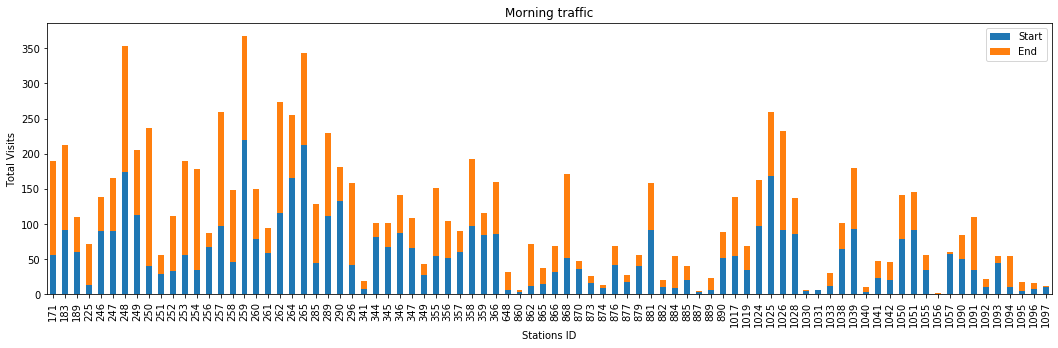

In [15]:
# Calculate the sum of the traffic at each station as start or end station in the morning
morning_start_or_end = [x + y for x, y in zip(listaa_count, listaa_end_count)]
total_df = pd.DataFrame(list(zip(listaa_end_df,morning_start_or_end)),columns =['Station_ID', 'Total'])
tot_mor = pd.DataFrame(list(zip(listaa_end_df,listaa_count, listaa_end_count)),columns =['Station_ID', 'Start', 'End'])
tot_mor[['Start','End']].plot(kind='bar', stacked=True, figsize=(18, 5))
x1 = list(range(0, 84))
plt.title('Morning traffic')
plt.xlabel('Stations ID')
plt.ylabel('Total Visits')
squad = tot_mor.Station_ID
plt.xticks(x1, squad, rotation = 90)
plt.show()

In [16]:
# find the highest value of the sum of the traffic and then find the station with the highest value
max_trf = max(morning_start_or_end)
index_max = np.argmax(total_df['Total'])
s = total_df['Station_ID']
station_of_total_max = s[index_max]
station_max_name = dataset[dataset["start_station_id"] == station_of_total_max].start_station_name.to_frame()
print("The station with the most traffic is station",station_max_name.iloc[0].start_station_name, "with id", station_of_total_max, "with total traffic", max_trf, "visits")

The station with the most traffic is station St Andrew Square with id 259 with total traffic 368 visits


### AFTERNOON TRIPS (12:00 - 23:59)

In [17]:
#group dataframe by start_station_id to find the most frequent end stations
listaa_after = afternoon_df.groupby("start_station_id").size()

#convert the series to list to be easier for later implementations
listaa_after_df = listaa_after.to_frame()
listaa_after_df = listaa_after_df.index.tolist()
listaa_after_count = listaa_after.tolist()

In [18]:
#initializing map for afternoon trips
afternoon = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=12
    )

#we put the start stations at the map assigning latitude and longitude
#we also use the number of times a trip started at the certain station to draw a radius
for i in range(len(listaa_after_df)):
    after_lon_s = afternoon_df[afternoon_df.start_station_id == listaa_after_df[i]].iloc[0].start_station_longitude
    after_lat_s = afternoon_df[afternoon_df.start_station_id == listaa_after_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[after_lat_s, after_lon_s],
    radius=listaa_after_count[i]/10,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(afternoon)

In [19]:
#group dataframe by end_station_id to find the most frequent end stations
after_list_for_end = afternoon_df.groupby("end_station_id").size()

#convert the series to list to be easier for later implementations
after_listaa_end_df = after_list_for_end.to_frame()
after_listaa_end_df = after_listaa_end_df.index.tolist()
after_listaa_end_count = after_list_for_end.tolist()

In [20]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(after_listaa_end_df)):
    after_lon_e = afternoon_df[afternoon_df.end_station_id == after_listaa_end_df[i]].iloc[0].end_station_longitude
    after_lat_e = afternoon_df[afternoon_df.end_station_id == after_listaa_end_df[i]].iloc[0].end_station_latitude    
    folium.CircleMarker(
    location=[after_lat_e, after_lon_e],
    radius=after_listaa_end_count[i]/10,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(afternoon)

#### On the following map we can see the afternoon trips which started from blue stations and ended in red stations. The radius of the cycle around each point shows how frequent the certain station was for the start and the end of trips.

In [21]:
afternoon

#### On the above map, we can observe that the most used stations are located in the city center. We observe that the red circles are larger as we get far from the city center, and that gives as the information that on the afternoon too, people use the bikes to get out of the city center, just like in the morning.

#### Below, we present a bar chart that shows the frequency of usage of each station in the afternoon as start or end station, and the sum of these frequencies, which gives us more clear intuition about each station's visits.

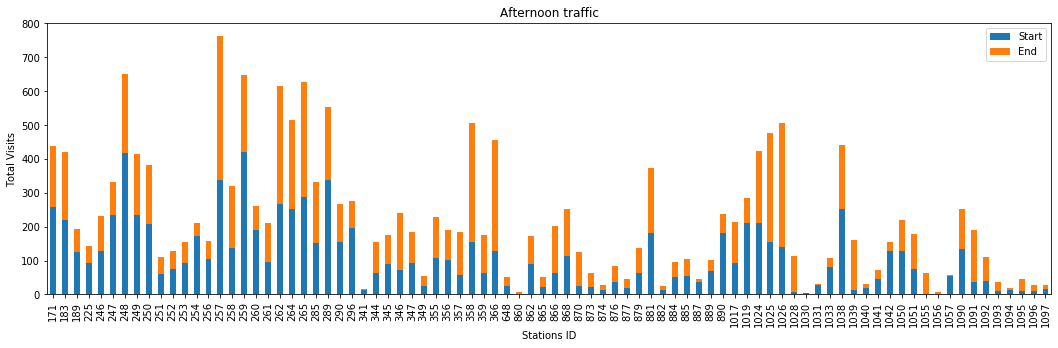

In [22]:
# Calculate the sum of the traffic at each station as start or end station in the afternoon
afternoon_start_or_end = [x + y for x, y in zip(listaa_after_count, after_listaa_end_count)]
total_afternoon_df = pd.DataFrame(list(zip(listaa_end_df,afternoon_start_or_end)),columns =['Station_ID', 'Total'])
tot_aft = pd.DataFrame(list(zip(after_listaa_end_df,listaa_after_count, after_listaa_end_count)),columns =['Station_ID', 'Start', 'End'])
tot_aft[['Start','End']].plot(kind='bar', stacked=True, figsize=(18, 5))
x1 = list(range(0, 84))
plt.title('Afternoon traffic')
plt.xlabel('Stations ID')
plt.ylabel('Total Visits')
squad = tot_aft.Station_ID
plt.xticks(x1, squad, rotation = 90)
plt.show()

In [23]:
# find the highest value of the sum of the traffic and the finding the station with the highest value
max_aft = max(afternoon_start_or_end)
index_max_af = np.argmax(total_afternoon_df['Total'])
saf = total_afternoon_df['Station_ID']
station_of_total_max_aft = saf[index_max_af]
station_max_name_aft = dataset[dataset["start_station_id"] == station_of_total_max_aft].start_station_name.to_frame()
print("The station with the most traffic is station",station_max_name_aft.iloc[0].start_station_name, "with id", station_of_total_max_aft, "with total traffic", max_aft, "visits")

The station with the most traffic is station Portobello with id 257 with total traffic 764 visits


#### As we can see from the two bar charts, in the morning the station with station_id 259,which is St Andrew Square, is the station with the highest traffic as start or end station overall. For the afteroon trips the most visited station is station with station-id 257, which is Portobello,with the highest traffic as start or end station overall.

#### As we can see from the two maps, there are many stations in the city center near to the Bristol Square and the Central University. However, it seems that these stations serve too many people, thus a new station there it would be a good idea. Another good site for a new station would be in the Princess Street, since there are very few stations there to serve the people, and these stations are very busy. In addition, WestEnd seems to be a busy site, however there are no many stations there to serve the people, and thus it would be a good idea to build an new station there. Another good point to build a new station, is on the east of the town, where it appears that there are almost no stations. Maybe a point between Portobello and Leight on the seaside would be a good idea, since these two stations appear to be very busy.

### WEEKENDS AND WEEKDAYS

#### We will now have a look through the bike rentals and comparing the usage between weekdays and weekends.

In [24]:
#divide dataset weekend and weedays
weekend_indices = []
weekdays_indices = []

for i in range(len(date_started)):
    if date_started[i].weekday() == 5 or date_started[i].weekday() == 6:
        weekend_indices.append(i)
    else:
        weekdays_indices.append(i)

In [25]:
weekend_df = dataset.iloc[weekend_indices]
weekdays_df = dataset.iloc[weekdays_indices]

In [26]:
#weekend and weekdays AVERAGE TRIP DURATION
print("The average time of bike rental in the weekend is: ", round(weekend_df.duration.mean()/60,1), " minutes")
print("The average time of bike rental in the weekdays is: ", round(weekdays_df.duration.mean()/60,1), " minutes")

The average time of bike rental in the weekend is:  31.8  minutes
The average time of bike rental in the weekdays is:  21.5  minutes


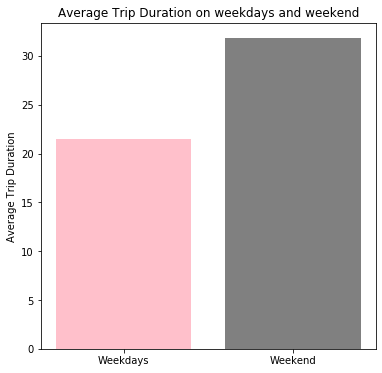

In [27]:
durations = [weekdays_df.duration.mean()/60, weekend_df.duration.mean()/60]
bars = ('Weekdays', 'Weekend')
y_pos = np.arange(len(bars))
plt.figure(figsize=(6,6))
plt.bar(y_pos, durations,color=['pink', 'grey'])
plt.title('Average Trip Duration on weekdays and weekend')
plt.ylabel('Average Trip Duration')
plt.xticks(y_pos, bars)
plt.show()

#### As we see from the analysis above, people tend to rent the bike for much more time in the weekends than in the weekdays. That may mean that people who use the bike in the weekend, they use it for entartainment and exercises, and people who use it in the weekdays, they use it for going to a certain point. We see that in the weekdays people rent the bike for an average duration of the trip to be 21.5 minutes, while the average duration for a rent in the weekend is 31.8 minutes. This is 10 more minutes per trip in the weekends compared to the weekdays.

#### Now we will look through the different times of the day, and compare the weekends and the weekdays.

In [28]:
#creating weekend and weekdays dataframes with hour groups
times_weekend = pd.to_datetime(weekend_df.started_at)
weekend_time = weekend_df.groupby(times_weekend.dt.hour).size()
times_weekdays = pd.to_datetime(weekdays_df.started_at)
weekdays_time = weekdays_df.groupby(times_weekdays.dt.hour).size()

In [29]:
#converting weekend and weekdays groups by time into list for easier implementation 
weekend_time_df = weekend_time.to_frame()
weekend_time_df = weekend_time_df.index.tolist()
weekend_time_count = weekend_time.tolist()

weekdays_time_df = weekdays_time.to_frame()
weekdays_time_df = weekdays_time_df.index.tolist()
weekdays_time_count = weekdays_time.tolist()

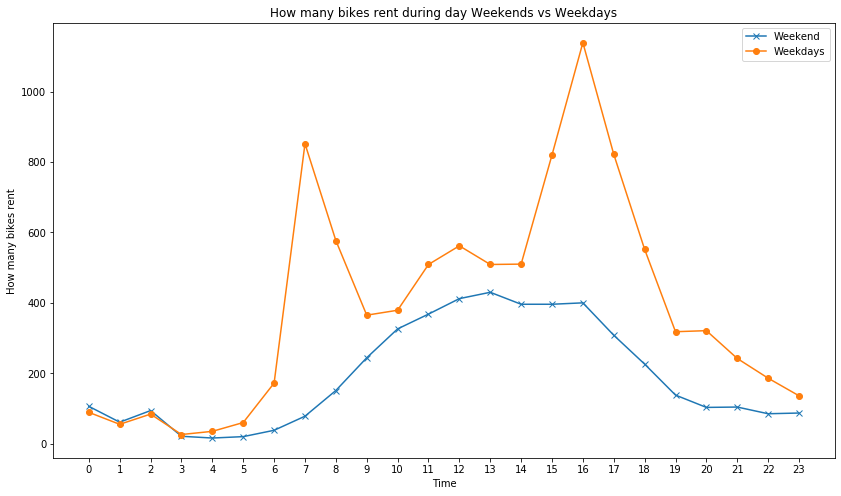

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.plot(weekend_time_count, marker='x')
plt.xticks([i for i in range(0,24)])
plt.plot(weekdays_time_count, marker='o')
plt.xlabel("Time")
plt.ylabel("How many bikes rent")
plt.title("How many bikes rent during day Weekends vs Weekdays")
plt.gca().legend(('Weekend','Weekdays'))
plt.show()

#### As we expected to happen, we observe that on the weekdays, the bike rentals hit a peak at around 07:00 and at around 16:00. These times, are when people travel to and from work, and then we can conclude that they use the bike to travel between home and work. In the weekends, the bike rentals are wider distributed, since we see that the bike rentals are on the maximum for many hours (from 11:00 to 16:00)

### LONG AND SHORT TRIPS

#### Below will make an analysis about the long and the short bike trips. We define long trips as the trips that have duration more than 20minutes.

In [31]:
long_trips = dataset[dataset.duration > 1200]
short_trips = dataset[dataset.duration <= 1200]

In [32]:
#group by start_stations and then converting pandas series to list for easier implementation of the following
long_list = long_trips.groupby("start_station_id").size()

long_list_df = long_list.to_frame()
long_list_df = long_list.index.tolist()
long_list_count = long_list.tolist()

In [33]:
#initializing map
long_t = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=13
    )

#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(long_list_df)):
    long_lon_s = long_trips[long_trips.start_station_id == long_list_df[i]].iloc[0].start_station_longitude
    long_lat_s = long_trips[long_trips.start_station_id == long_list_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[long_lat_s, long_lon_s],
    radius= long_list_count[i]/10,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(long_t)

In [34]:
#group by start_stations and then converting pandas series to list for easier implementation of the following
long_list_end = long_trips.groupby("end_station_id").size()

long_list_end_df = long_list_end.to_frame()
long_list_end_df = long_list_end.index.tolist()
long_list_end_count = long_list_end.tolist()

In [35]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(long_list_end_df)):
    long_lon_e = long_trips[long_trips.end_station_id == long_list_end_df[i]].iloc[0].end_station_longitude
    long_lat_e = long_trips[long_trips.end_station_id == long_list_end_df[i]].iloc[0].end_station_latitude
    
    folium.CircleMarker(
    location=[long_lat_e, long_lon_e],
    radius= long_list_end_count[i]/10,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(long_t)

#### Below we visualize the long trips in a map. The long trips start from the blue stations and end in the red stations.

In [36]:
long_t

#### From the above map, we can see that the long trips are started from and ended to the parts outside the city center. The most frequent stations for the long trips are Portobello and the north part of Edinburgh (Leith). 

### COMPARE LONG AND SHORT TRIPS 

#### Now we will compare the long and short trips.

In [37]:
#initializing map
compare_long_short = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=13
    )

#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(long_list_df)):
    long_lon_s = long_trips[long_trips.start_station_id == long_list_df[i]].iloc[0].start_station_longitude
    long_lat_s = long_trips[long_trips.start_station_id == long_list_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[long_lat_s, long_lon_s],
    radius= long_list_count[i]/10,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(compare_long_short)

In [38]:
#group by start_stations and then converting pandas series to list for easier implementation in the map
short_list = short_trips.groupby("start_station_id").size()
short_list_df = short_list.to_frame()
short_list_df = short_list.index.tolist()
short_list_count = short_list.tolist()

In [39]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(short_list_df)):
    short_lon_s = short_trips[short_trips.start_station_id == short_list_df[i]].iloc[0].start_station_longitude
    short_lat_s = short_trips[short_trips.start_station_id == short_list_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[short_lat_s, short_lon_s],
    radius= short_list_count[i]/10,
    color='green',
    fill=True,
    fill_color='green'
    ).add_to(compare_long_short)

#### On the map below, we can see how the trips' starting points are distributed through the city. The long trips start from blue stations, and short trips start from green ones.

In [40]:
compare_long_short

#### As we observe in the above map, the long trips start from the far points of the city. We see that the green points are very frequent in the city center, which means that when people rent a bike from the city center, they appear to travel for a short time to near points. When people rent a bike from stations which are not in the city center, they tend to do long trips as we see from the blue circles.

### SUMMER 2019

#### We will now do some analysis on the three summer months.

In [41]:
data_path = os.path.join(os.getcwd(), 'cyclingtrips_June2019.csv')
datasetJune = pd.read_csv(data_path, delimiter = ',', parse_dates=['started_at', 'ended_at'])

data_path = os.path.join(os.getcwd(), 'cyclingtrips_July2019.csv')
datasetJuly = pd.read_csv(data_path, delimiter = ',', parse_dates=['started_at', 'ended_at'])

data_path = os.path.join(os.getcwd(), 'cyclingtrips_Aug2019.csv')
datasetAug = pd.read_csv(data_path, delimiter = ',', parse_dates=['started_at', 'ended_at'])

In [42]:
datasetJune.duration.describe()

count    10214.000000
mean      1715.896319
std       2539.130851
min         61.000000
25%        628.000000
50%       1073.500000
75%       2203.000000
max      79921.000000
Name: duration, dtype: float64

In [43]:
datasetJuly.duration.describe()

count     12290.000000
mean       1738.477950
std        3937.385125
min          61.000000
25%         634.000000
50%        1086.000000
75%        2233.000000
max      331450.000000
Name: duration, dtype: float64

In [44]:
datasetAug.duration.describe()

count     17140.000000
mean       1516.119545
std        2443.342016
min          61.000000
25%         594.000000
50%         970.000000
75%        1804.000000
max      190513.000000
Name: duration, dtype: float64

##### In June and July we can say that we observe a similar distribution on the rent duration, since the rents in July were a litle more than those on June, and the average duration in these two months was about 30minutes. In addition, in June and July, 25% of people rent the bike for less than 10minutes. Half of the people rent the bike for less than 20 minutes. This pattern changed in August. It is obvious at a first glance, that the number of rents in August is signifficantly greater than the rents in June and July. However, the average duration in August was 25 minutes, while only a 25% rent the bike for more than 30 minutes. Half of the people who rent a bike, he used it for less than 15 minutes, and hence we can understand that the short trips were a lot more than the long ones.



#### Now will visualize in a map the rent frequency in every station for the three summer months

In [45]:
june_stations = datasetJune.groupby("start_station_id").size()

june_stations_df = june_stations.to_frame()
june_stations_df = june_stations_df.index.tolist()
june_stations_count = june_stations.tolist()

In [46]:
#initializing map
summer = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=13
    )

#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(june_stations_df)):
    june_lon_s = datasetJune[datasetJune.start_station_id == june_stations_df[i]].iloc[0].start_station_longitude
    june_lat_s = datasetJune[datasetJune.start_station_id == june_stations_df[i]].iloc[0].start_station_latitude
    folium.CircleMarker(
    location=[june_lat_s, june_lon_s],
    radius= june_stations_count[i]/15,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(summer)

In [47]:
july_stations = datasetJuly.groupby("start_station_id").size()
#morning_df.groupby("start_station_id").get_group(290)
july_stations_df = july_stations.to_frame()
july_stations_df = july_stations_df.index.tolist()
july_stations_count = july_stations.tolist()

In [48]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(july_stations_df)):
    july_lon_s = datasetJuly[datasetJuly.start_station_id == july_stations_df[i]].iloc[0].start_station_longitude
    july_lat_s = datasetJuly[datasetJuly.start_station_id == july_stations_df[i]].iloc[0].start_station_latitude    
    folium.CircleMarker(
    location=[july_lat_s, july_lon_s],
    radius= july_stations_count[i]/15,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(summer)

In [49]:
aug_stations = datasetAug.groupby("start_station_id").size()
#morning_df.groupby("start_station_id").get_group(290)
aug_stations_df = aug_stations.to_frame()
aug_stations_df = aug_stations_df.index.tolist()
aug_stations_count = aug_stations.tolist()

In [50]:
for i in range(len(aug_stations_df)):
    aug_lon_s = datasetAug[datasetAug.start_station_id == aug_stations_df[i]].iloc[0].start_station_longitude
    aug_lat_s = datasetAug[datasetAug.start_station_id == aug_stations_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[aug_lat_s, aug_lon_s],
    radius= aug_stations_count[i]/15,
    color='yellow',
    fill=True,
    fill_color='yellow'
    ).add_to(summer)

#### Below we see the trips started from certain station during June (red), July (blue) and August (yellow)

In [51]:
summer

#### Observing the above map, we see that in August (yellow) there are too many bike rentals. This extreme difference which is observed between the same stations in June-July and August is because of the tourism in August in Edinburgh. We see that people use way to much the city center stations to rent a bike, and the other stations which are outside the city center, appear to have similar numbers of rentals through the three summer months.

### WEEKDAYS AND WEEKENDS IN AUGUST AND SEPTEMBER

#### We will now try to see if there is any difference in the time distribution in weekdays and weekends, between August and September.

In [52]:
#divide dataset in weekend and weekdays in AUGUST
date_started_aug = (datasetAug["started_at"])
weekend_indices_aug = []
weekdays_indices_aug = []

#weekend and weekdays indices
for i in range(len(date_started_aug)):
    if date_started_aug[i].weekday() == 5 or date_started_aug[i].weekday() == 6:
        weekend_indices_aug.append(i)
    else:
        weekdays_indices_aug.append(i)

In [53]:
weekend_aug_df = datasetAug.iloc[weekend_indices_aug]
weekdays_aug_df = datasetAug.iloc[weekdays_indices_aug]

In [54]:
#creating weekend and weekdays dataframes with hour groups
times_weekend_aug = pd.to_datetime(weekend_aug_df.started_at)
weekend_time_aug = weekend_aug_df.groupby(times_weekend_aug.dt.hour).size()
times_weekdays_aug = pd.to_datetime(weekdays_aug_df.started_at)
weekdays_time_aug = weekdays_aug_df.groupby(times_weekdays_aug.dt.hour).size()

In [55]:
#converting weekend and weekdays groups by time into list for easier implementation 
weekend_time_df_aug = weekend_time_aug.to_frame()
weekend_time_df_aug = weekend_time_df_aug.index.tolist()
weekend_time_count_aug = weekend_time_aug.tolist()

weekdays_time_df_aug = weekdays_time_aug.to_frame()
weekdays_time_df_aug = weekdays_time_df_aug.index.tolist()
weekdays_time_count_aug = weekdays_time_aug.tolist()

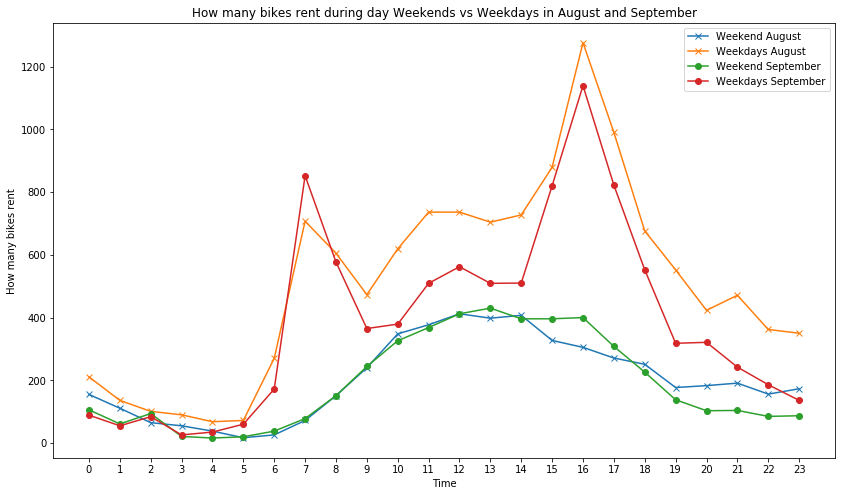

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.plot(weekend_time_count_aug, marker='x')
plt.xticks([i for i in range(0,24)])
plt.plot(weekdays_time_count_aug, marker='x')

plt.plot(weekend_time_count, marker='o')
plt.plot(weekdays_time_count, marker='o')


plt.xlabel("Time")
plt.ylabel("How many bikes rent")
plt.title("How many bikes rent during day Weekends vs Weekdays in August and September")
plt.gca().legend(('Weekend August','Weekdays August', "Weekend September", "Weekdays September"))
plt.show()

#### At a first glance, it seems that the pattern between these two months is almost the same. This happens for sure at the weekends, when the number of bike rents is almost the same for the whole day for August and September. In the weekdays we observe some differences between the two months. In the morning, in September the rentals were more than in August due to the fact that many people in August are on leave. However, later on the day, in August we observe more rentals from 8am until night. 

### COMPARE THE "MOST SUMMER" TO THE "MOST WINTER" MONTH (JULY VS JANUARY)

In [57]:
data_path = os.path.join(os.getcwd(), 'cyclingtrips_Jan2019.csv')
datasetJan = pd.read_csv(data_path, delimiter = ',', parse_dates=['started_at', 'ended_at'])

In [58]:
#converting groups by stations into list for easier implementation 
jan_stations = datasetJan.groupby("start_station_id").size()

jan_stations_df = jan_stations.to_frame()
jan_stations_df = jan_stations_df.index.tolist()
jan_stations_count = jan_stations.tolist()

In [59]:
#initializing map
javVSjuly = folium.Map(
    location=[55.954906, -3.192444],
    zoom_start=13
    )

#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(jan_stations_df)):
    jan_lon_s = datasetJan[datasetJan.start_station_id == jan_stations_df[i]].iloc[0].start_station_longitude
    jan_lat_s = datasetJan[datasetJan.start_station_id == jan_stations_df[i]].iloc[0].start_station_latitude
    folium.CircleMarker(
    location=[jan_lat_s, jan_lon_s],
    radius= jan_stations_count[i]/15,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(javVSjuly)

In [60]:
#we put the end stations at the map assigning latitude and longitude
#we also use the number of times a trip ended at the certain station to draw a radius
for i in range(len(july_stations_df)):
    july_lon_s = datasetJuly[datasetJuly.start_station_id == july_stations_df[i]].iloc[0].start_station_longitude
    july_lat_s = datasetJuly[datasetJuly.start_station_id == july_stations_df[i]].iloc[0].start_station_latitude
    
    folium.CircleMarker(
    location=[july_lat_s, july_lon_s],
    radius= july_stations_count[i]/15,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(javVSjuly)

In [61]:
javVSjuly

#### As we expected, the rentals in January (blue) are much less than the rentals in July (red). However, it is noticable that the stations with the most rentals in January, are also the ones with the most rentals in July too. This leads to the conclusion that although there are some flunctuations on the number of rentals each month, the most popular stations are the same during the whole year.

### NEW YORK VS EDINBURGH IN SEPTEMBER

#### We will now try to compare the bike rentals in New York and Edinburgh in September. The dataset for New York has some differences compared to the datasets of Edinburgh as we will see below.

In [62]:
data_path = os.path.join(os.getcwd(), 'JC-201909-citibike-tripdata.csv')
datasetNY = pd.read_csv(data_path, delimiter = ',', parse_dates = ["starttime", "stoptime"])

In [63]:
datasetNY.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,145,2019-09-01 00:00:37.692,2019-09-01 00:03:03.010,3640,Journal Square,40.733670,-74.062500,3206,Hilltop,40.731169,-74.057574,29303,Subscriber,1991,1
1,212,2019-09-01 00:03:00.600,2019-09-01 00:06:33.342,3194,McGinley Square,40.725340,-74.067622,3679,Bergen Ave,40.722104,-74.071455,29297,Subscriber,1993,2
2,569,2019-09-01 00:07:13.002,2019-09-01 00:16:42.861,3214,Essex Light Rail,40.712774,-74.036486,3184,Paulus Hook,40.714145,-74.033552,29435,Customer,1977,1
3,1380,2019-09-01 00:07:25.335,2019-09-01 00:30:26.164,3214,Essex Light Rail,40.712774,-74.036486,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,29509,Subscriber,1965,1
4,1346,2019-09-01 00:07:56.467,2019-09-01 00:30:22.544,3214,Essex Light Rail,40.712774,-74.036486,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,29226,Subscriber,1968,2


In [64]:
# Divide dataset in weekend and weekdays in September
date_started_sept_ny = (datasetNY["starttime"])
weekend_indices_sept_ny = []
weekdays_indices_sept_ny = []

for i in range(len(date_started_sept_ny)):
    if date_started_sept_ny[i].weekday() == 5 or date_started_sept_ny[i].weekday() == 6:
        weekend_indices_sept_ny.append(i)
    else:
        weekdays_indices_sept_ny.append(i)

In [65]:
#creating dataframes from indices
weekend_sept_ny_df = datasetNY.iloc[weekend_indices_sept_ny]
weekdays_sept_ny_df = datasetNY.iloc[weekdays_indices_sept_ny]

In [66]:
#creating weekend and weekdays dataframes with hour groups for NY dataset
times_weekend_sept_ny = pd.to_datetime(weekend_sept_ny_df.starttime)
weekend_time_sept_ny = weekend_sept_ny_df.groupby(times_weekend_sept_ny.dt.hour).size()
times_weekdays_sept_ny = pd.to_datetime(weekdays_sept_ny_df.starttime)
weekdays_time_sept_ny = weekdays_sept_ny_df.groupby(times_weekdays_sept_ny.dt.hour).size()

In [67]:
#converting groups by stations into list for easier implementation 
weekend_time_df_sept_ny = weekend_time_sept_ny.to_frame()
weekend_time_df_sept_ny = weekend_time_df_sept_ny.index.tolist()
weekend_time_count_sept_ny = weekend_time_sept_ny.tolist()

weekdays_time_df_sept_ny = weekdays_time_sept_ny.to_frame()
weekdays_time_df_sept_ny = weekdays_time_df_sept_ny.index.tolist()
weekdays_time_count_sept_ny = weekdays_time_sept_ny.tolist()

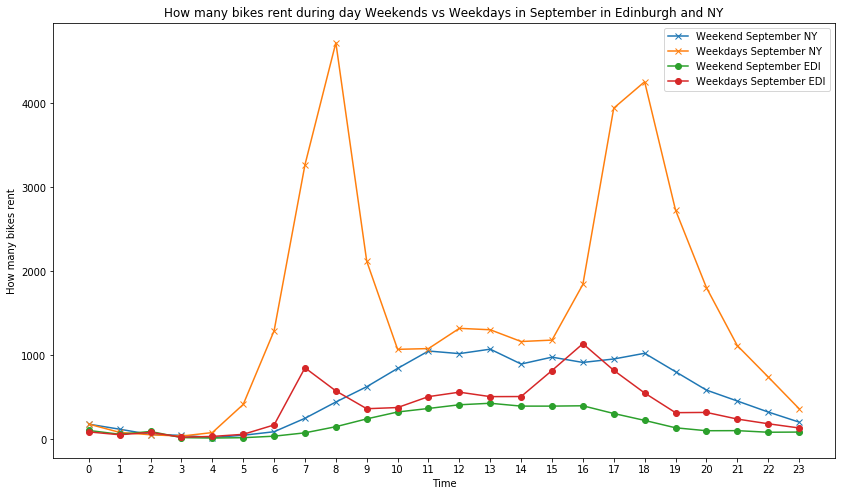

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.plot(weekend_time_count_sept_ny, marker='x')
plt.xticks([i for i in range(0,24)])
plt.plot(weekdays_time_count_sept_ny, marker='x')

plt.plot(weekend_time_count, marker='o')
plt.plot(weekdays_time_count, marker='o')


plt.xlabel("Time")
plt.ylabel("How many bikes rent")
plt.title("How many bikes rent during day Weekends vs Weekdays in September in Edinburgh and NY")
plt.gca().legend(('Weekend September NY','Weekdays September NY', "Weekend September EDI", "Weekdays September EDI"))
plt.show()

#### We can observe that in New York in September regardless of the day, weekend or not, more bikes are rented than in Edinburgh. We also observe that the two cities have many similarities when we talk about the rents distribution through the day. Both cities peak in the morning when people go to work, and in the afternoon when people return from work. However what we can see, is that people in Edinburgh go to and leaves from the work earlier than people in NY.  The big difference between the two cities is observed in the weekends. As mentioned above, people in NY rent more bikes than people in Edinburgh. However, if we look more carefully, we observe that the ratio of weekdays/weekends in NY is much higher that the ration in Edinburgh. That could mean that people in Edinburgh rent bikes even in the weekends for entertainment and exercise, while a small proportion of people in NY use the bikes for these reasons.

### LOS ANGELES VS EDINBURGH IN SEPTEMBER

#### We tried to find another one dataset in order to make our analysis more complete. So, we tried to analyze the bike rentals in Los Angeles, and compare the results to bike rentals in Edinburgh in September. Again, the dataset has a different format.

In [69]:
data_path = os.path.join(os.getcwd(), 'metro-bike-share-trips-2019_sept_LA.csv')
datasetLA = pd.read_csv(data_path, delimiter = ',', parse_dates = ["start_time", "end_time"])
datasetLA.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,128288892,19,2019-09-01 00:00:00,2019-09-01 00:19:00,4311,34.059689,-118.294662,4410,34.063351,-118.296799,17327,30,One Way,Monthly Pass,electric
1,128288891,23,2019-09-01 00:05:00,2019-09-01 00:28:00,3074,34.044170,-118.261169,3047,34.039982,-118.266403,11981,30,One Way,Monthly Pass,standard
2,128288890,14,2019-09-01 00:08:00,2019-09-01 00:22:00,3006,34.045540,-118.256668,3018,34.043732,-118.260139,18258,30,One Way,Monthly Pass,electric
3,128288889,17,2019-09-01 00:11:00,2019-09-01 00:28:00,3005,34.048500,-118.258537,3082,34.046520,-118.237411,5997,1,One Way,Walk-up,standard
4,128288888,16,2019-09-01 00:12:00,2019-09-01 00:28:00,3005,34.048500,-118.258537,3082,34.046520,-118.237411,17068,1,One Way,Walk-up,electric


In [70]:
#divide dataset in weekend and weekdays in September
date_started_sept_la = (datasetLA["start_time"])
weekend_indices_sept_la = []
weekdays_indices_sept_la = []

#weekends and weekdays indices
for i in range(len(date_started_sept_la)):
    if date_started_sept_la[i].weekday() == 5 or date_started_sept_la[i].weekday() == 6:
        weekend_indices_sept_la.append(i)
    else:
        weekdays_indices_sept_la.append(i)

In [71]:
#creating the dataframes from indices
weekend_sept_la_df = datasetLA.iloc[weekend_indices_sept_la]
weekdays_sept_la_df = datasetLA.iloc[weekdays_indices_sept_la]

In [72]:
#creating weekend and weekdays dataframes with hour groups for NY dataset
times_weekend_sept_la = pd.to_datetime(weekend_sept_la_df.start_time)
weekend_time_sept_la = weekend_sept_la_df.groupby(times_weekend_sept_la.dt.hour).size()
times_weekdays_sept_la = pd.to_datetime(weekdays_sept_la_df.start_time)
weekdays_time_sept_la = weekdays_sept_la_df.groupby(times_weekdays_sept_la.dt.hour).size()

In [73]:
#converting groups by stations into list for easier implementation of the following
weekend_time_df_sept_la = weekend_time_sept_la.to_frame()
weekend_time_df_sept_la = weekend_time_df_sept_la.index.tolist()
weekend_time_count_sept_la = weekend_time_sept_la.tolist()

weekdays_time_df_sept_la = weekdays_time_sept_la.to_frame()
weekdays_time_df_sept_la = weekdays_time_df_sept_la.index.tolist()
weekdays_time_count_sept_la = weekdays_time_sept_la.tolist()

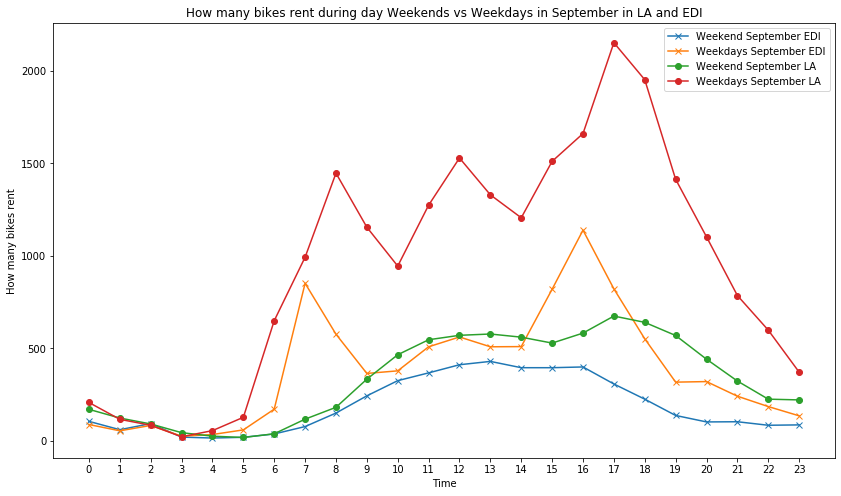

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.plot(weekend_time_count, marker='x')
plt.xticks([i for i in range(0,24)])
plt.plot(weekdays_time_count, marker='x')
plt.plot(weekend_time_count_sept_la, marker='o')
plt.plot(weekdays_time_count_sept_la, marker='o')
plt.xlabel("Time")
plt.ylabel("How many bikes rent")
plt.title("How many bikes rent during day Weekends vs Weekdays in September in LA and EDI")
plt.gca().legend(('Weekend September EDI','Weekdays September EDI', "Weekend September LA", "Weekdays September LA"))
plt.show()

#### In this plot we observe very similar results as in the comparison of NY and Edinburgh. We see that people have certain times that rent the bikes in the weekdays in the three cities we have compared. We can observe the same thing about the ratio weekdays/weekend rentals in LA as in NY, but it is in a lower level. Although the total number of rentals in Edinburgh is significantly lower than the number in LA, it seems that in the weekends the numbers are very close. This means that people in Edinburgh rent bikes in weekends too, while people in LA and NY, as we saw before, don't.

### AVERAGE DURATION FOR EDI, NY, LA IN SEPTEMBER

#### We will try to compare the trip duration in the three cities in September.

In [75]:
# finding the mean duration for Edinburgh, New York and Los Angeles
edi_mean = dataset.duration.mean()/60
ny_mean = datasetNY.tripduration.mean()/60
la_mean = datasetLA.duration.mean() #duration given in minutes

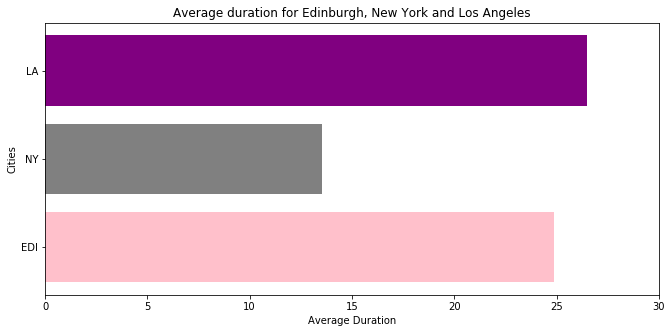

In [76]:
import numpy as np
plt.figure(figsize=(11,5))
means = [edi_mean, ny_mean, la_mean]
means_names = ("EDI", "NY", "LA")
y_pos = np.arange(len(means_names))
plt.barh(y_pos, means, color=['pink', 'grey', 'purple'])
plt.yticks(y_pos, means_names)
plt.xlim(0,30)
plt.xlabel("Average Duration")
plt.ylabel("Cities")
plt.title("Average duration for Edinburgh, New York and Los Angeles")
plt.show()

#### As we can see that the average duration of the trips in  Edinburgh and Los Angeles is almost the same,rather than Edinburgh is the smallest city amongst these three. However, in New York the average trip duration is almost the half compared with the other two cities. 

#### Finally, we will take a look through the different types of bike rentals in Los Angeles.

In [77]:
# finding the number of each type of bike
LA_bike_type = datasetLA.groupby("bike_type").size()
LA_bike_type_df = LA_bike_type.to_frame()
LA_bike_type_df = LA_bike_type_df.index.tolist()
LA_bike_type_count = LA_bike_type.tolist()

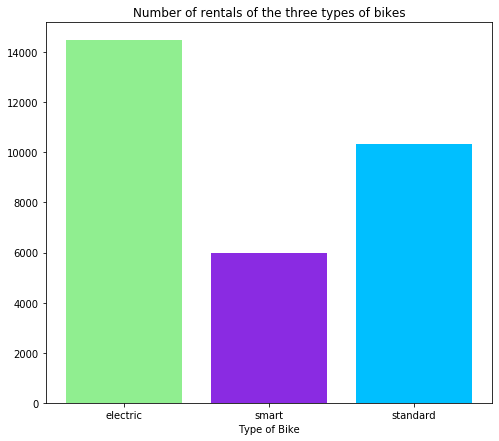

In [78]:
bike_type = LA_bike_type_count
bars = (LA_bike_type_df)
y_pos = np.arange(len(bars))
plt.figure(figsize=(8,7))
plt.bar(y_pos, bike_type, color=['lightgreen', 'blueviolet', 'deepskyblue'])
plt.xticks(y_pos, bars)
plt.xlabel("Type of Bike")
plt.title("Number of rentals of the three types of bikes")
plt.show()

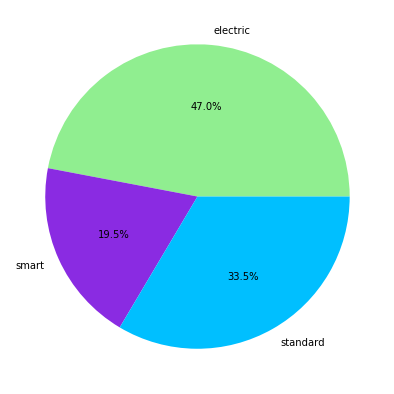

In [79]:
plt.figure(figsize=(13,7))
plt.pie(x = bike_type, labels = ["electric", "smart", "standard"], autopct='%1.1f%%', colors=['lightgreen', 'blueviolet', 'deepskyblue'])
plt.show()

#### As we can see from the two plots above, roughly half of the people who use bikes, rent electric bikes, while around a third uses standard bike. The least popular type amongst the three types of bikes is the smart bikes, since only around 20% use them.


#### We look through the average trip duration for each type of bike in LA.

In [80]:
duration_bike = datasetLA[['duration','bike_type']]
#duration_bike

electric_duration = duration_bike[duration_bike["bike_type"] == "electric"]
standard_duration = duration_bike[duration_bike["bike_type"] == "standard"]
smart_duration = duration_bike[duration_bike["bike_type"] == "smart"]

In [81]:
#finding the average duration for the thre types of bikes
electric_mean = electric_duration.duration.mean()
standard_mean = standard_duration.duration.mean()
smart_mean = smart_duration.duration.mean()

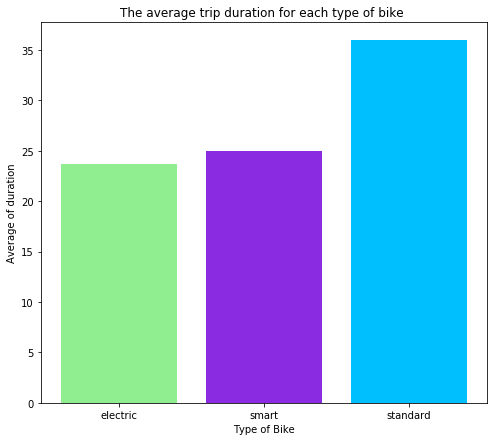

In [82]:
mean_type = [electric_mean,standard_mean,smart_mean]
bars = (LA_bike_type_df)
y_pos = np.arange(len(bars))
plt.figure(figsize=(8,7))
plt.bar(y_pos, mean_type,color=['lightgreen', 'blueviolet', 'deepskyblue'])
plt.xticks(y_pos, bars)
plt.xlabel("Type of Bike")
plt.ylabel("Average of duration")
plt.title("The average trip duration for each type of bike ")
plt.show()

#### As we can see from the above plot, people who use standard bikes tend to do longer trips (average 35minutes), comparing to people who rent electric or smart bikes (around 25 minutes).